In [321]:
#need volatility data and the data from the risk_adjusted_returns file:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Get volatility historical data:
url_volatility = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/volatility_data.csv'
volatility_df = pd.read_csv(url_volatility)
#make the date a datetime object:
volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])

# first we need the historical data: 
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/QQQ.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns:
price_df['r_ndq'] = (price_df['Adj Close'] - price_df['Adj Close'].shift(1)) / price_df['Adj Close'].shift(1)
price_df.dropna(inplace=True)
price_df.head()

rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/IEF.csv')
rf_df['r_rf'] = (rf_df['Adj Close'] - rf_df['Adj Close'].shift(1)) / rf_df['Adj Close'].shift(1)
rf_df.dropna(inplace=True)
rf_df['Date'] = pd.to_datetime(rf_df['Date'])

portfolio_df = pd.merge(price_df[['Date', 'r_ndq']], 
                     rf_df[['Date', 'r_rf']], 
                     on='Date', 
                     how='inner')

portfolio_df = pd.merge(portfolio_df,  
                     volatility_df[['Date', 'Price']],
                     on='Date', 
                     how='inner')

portfolio_df.rename(columns={'Price' : 'Volatility'}, inplace = True)
portfolio_df.head()


,Date,r_ndq,r_rf,Volatility
0,2015-01-05,-0.014669,0.006101,18.00
1,2015-01-06,-0.013408,0.006718,19.05
2,2015-01-07,0.012891,-0.000186,17.20
3,2015-01-08,0.019140,-0.004079,16.61
4,2015-01-09,-0.006583,0.004933,16.60


In [322]:
r = 14
s = 16
w_ndq = []
w_rf = []
for i in range(len(portfolio_df)):
    if portfolio_df['Volatility'][i] > s:
        w_ndq.append(0)
        w_rf.append(1)
    elif (portfolio_df['Volatility'][i] <= s) and (portfolio_df['Volatility'][i] > r):
        w_ndq.append(0.6)
        w_rf.append(0.4)
    else:
        w_ndq.append(1)
        w_rf.append(0)

In [323]:
len(w_rf)

1256

In [324]:
w_rf = np.array(w_rf)
w_ndq = np.array(w_ndq)

In [325]:
w_ndq

array([0. , 0. , 0. , ..., 1. , 0.6, 0.6])

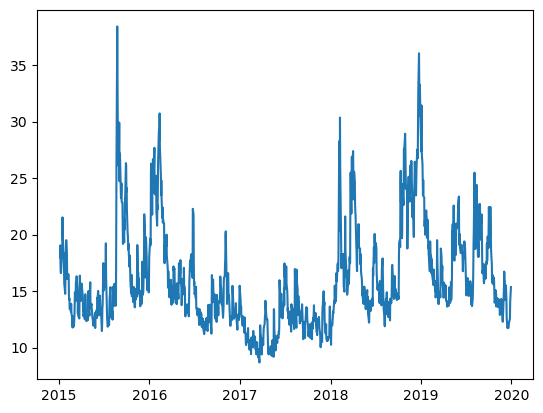

In [326]:
plt.plot(portfolio_df['Date'], portfolio_df['Volatility'])

In [327]:
len(portfolio_df)

1256

Next, calculate the portfolio returns based on the weights:
- best way: add the weights as columns in the dataframe?

In [328]:
# Adding arrays as columns to the DataFrame
portfolio_df['w_ndq'] = w_ndq
portfolio_df['w_rf'] = w_rf

portfolio_df.head()

,Date,r_ndq,r_rf,Volatility,w_ndq,w_rf
0,2015-01-05,-0.014669,0.006101,18.00,0.0,1.0
1,2015-01-06,-0.013408,0.006718,19.05,0.0,1.0
2,2015-01-07,0.012891,-0.000186,17.20,0.0,1.0
3,2015-01-08,0.019140,-0.004079,16.61,0.0,1.0
4,2015-01-09,-0.006583,0.004933,16.60,0.0,1.0


In [329]:
portfolio_df['r_portfolio'] = portfolio_df['w_ndq']*portfolio_df['r_ndq'] + portfolio_df['w_rf']*portfolio_df['r_rf']

In [330]:
#portfolio_df.set_index('Date', inplace=True)
portfolio_df.head()

,Date,r_ndq,r_rf,Volatility,w_ndq,w_rf,r_portfolio
0,2015-01-05,-0.014669,0.006101,18.00,0.0,1.0,0.006101
1,2015-01-06,-0.013408,0.006718,19.05,0.0,1.0,0.006718
2,2015-01-07,0.012891,-0.000186,17.20,0.0,1.0,-0.000186
3,2015-01-08,0.019140,-0.004079,16.61,0.0,1.0,-0.004079
4,2015-01-09,-0.006583,0.004933,16.60,0.0,1.0,0.004933


In [331]:
r_rf_df = pd.read_csv('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/risk_free_rate.csv')

#divide by 100 because it was already in % -> we dont want that here!
#then divide by 252 since its on a yearly basis but everything else is on a daily basis
#(252 ~ number of us trading days a year)
r_rf_df['rf_rate'] = r_rf_df['rf_rate']/(100*252)
r_rf_df['Date'] = pd.to_datetime(r_rf_df['Date'])
#r_rf_df.set_index('Date', inplace=True)
r_rf_df.head()


,Unnamed: 0,Date,rf_rate
0,250,2015-01-02,7.936508e-07
1,249,2015-01-05,1.190476e-06
2,248,2015-01-06,1.190476e-06
3,247,2015-01-07,1.190476e-06
4,246,2015-01-08,1.190476e-06


In [332]:
portfolio_df = pd.merge(portfolio_df, 
                        r_rf_df[['Date', 'rf_rate']], 
                        on='Date', 
                        how='inner')

In [333]:
sentiment_index_df = pd.read_excel('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/index/sentiment_index_unweighted_v4_new.xlsx')
sentiment_index_df.rename(columns={'date':'Date'}, inplace=True)
sentiment_index_df['lag_sentiment'] = sentiment_index_df['sentiment_score'].shift(1)
sentiment_index_df.head()

portfolio_df_sent = pd.merge(portfolio_df, sentiment_index_df, on='Date', how='inner')
portfolio_df_sent.set_index('Date', inplace=True)
portfolio_df_sent['moving_average_10day'] = portfolio_df_sent['sentiment_score'].rolling(window = 10).mean()

In [334]:

portfolio_df.set_index('Date', inplace=True)
portfolio_df_roll = portfolio_df['2018-05-01':].copy()
portfolio_df = portfolio_df['2019-01-01':] #just look at training data to optimize thresholds for now

In [335]:
portfolio_df_roll.head()

,r_ndq,r_rf,Volatility,w_ndq,w_rf,r_portfolio,rf_rate
Date,,,,,,,
2018-05-01,0.011433,-0.001567,17.38,0.0,1.0,-0.001567,0.000073
2018-05-02,-0.005898,0.000197,17.42,0.0,1.0,0.000197,0.000073
2018-05-03,-0.000123,0.002565,18.25,0.0,1.0,0.002565,0.000073
2018-05-04,0.018974,0.000098,16.68,0.0,1.0,0.000098,0.000073
2018-05-07,0.008310,-0.000492,16.13,0.0,1.0,-0.000492,0.000074


In [336]:
portfolio_df.head()

,r_ndq,r_rf,Volatility,w_ndq,w_rf,r_portfolio,rf_rate
Date,,,,,,,
2019-01-02,0.004019,0.002111,27.36,0.0,1.0,0.002111,0.000096
2019-01-03,-0.032670,0.007948,31.43,0.0,1.0,0.007948,0.000096
2019-01-04,0.042785,-0.008076,27.29,0.0,1.0,-0.008076,0.000096
2019-01-07,0.011906,-0.002778,26.25,0.0,1.0,-0.002778,0.000098
2019-01-08,0.009045,-0.002497,25.11,0.0,1.0,-0.002497,0.000098


In [483]:
def overall_sharpe_volatility_precentiles(vol):
    w_ndq = []
    w_rf = []

    # Assuming 'sentiment' is a pandas Series
    upper = portfolio_df_roll['Volatility'].shift(1).rolling(20, min_periods = 1).quantile(0.66)
    lower = portfolio_df_roll['Volatility'].shift(1).rolling(20, min_periods = 1).quantile(0.33)
    test_sent = vol['2019-01-01':]
    for i in test_sent.index:
        score = vol[i]
        if score > upper[i]: #23: changing to see if it improves
            w_ndq.append(0.2)
            w_rf.append(0.8)
        elif score <= upper[i] and score > lower[i]: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= lower[i]:
            w_ndq.append(0.8)
            w_rf.append(0.2)
    portfolio_df['w_ndq'] = w_ndq
    portfolio_df['w_rf'] = w_rf
    portfolio_df['r_portfolio'] = portfolio_df['w_ndq'] * portfolio_df['r_ndq'] + portfolio_df['w_rf'] * portfolio_df['r_rf']
    portfolio_df['excess returns'] = portfolio_df['r_portfolio'] - portfolio_df['rf_rate']
    portfolio_df['trading day'] = (portfolio_df['w_ndq'] != portfolio_df['w_ndq'].shift(1)).astype(int)
    mean_return_portfolio = portfolio_df['r_portfolio'].mean()
    std_excess = np.std(portfolio_df['excess returns'])
    mean_risk_free_rate = portfolio_df['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_excess
    return sharpe_ratio, upper, lower

In [484]:
sharpe, upper, lower = overall_sharpe_volatility_precentiles(portfolio_df_roll['Volatility'])

In [485]:
sharpe

0.3794806284109897

In [486]:
portfolio_df_roll['vol_moving_average_10day'] = portfolio_df_roll['Volatility'].rolling(window = 10).mean()

In [487]:
overall_sharpe_volatility_precentiles(portfolio_df_roll['vol_moving_average_10day'])[0]

0.2164103627359697

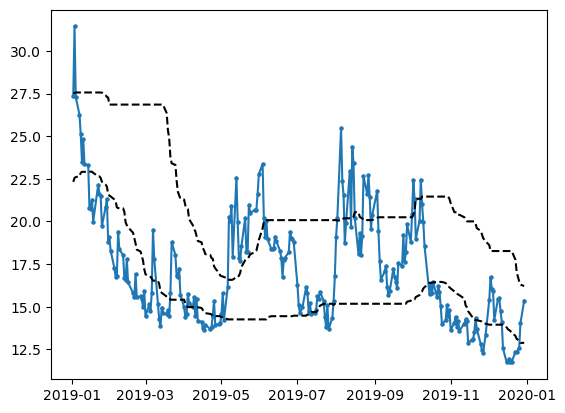

In [355]:
plt.plot(portfolio_df_roll['Volatility']['2019-01-01':])
plt.scatter(portfolio_df_roll['Volatility']['2019-01-01':].index, portfolio_df_roll['Volatility']['2019-01-01':], s = 5)
plt.plot(upper['2019-01-01':], color = 'black', linestyle = '--')
plt.plot(lower['2019-01-01':], color = 'black', linestyle = '--')

In [350]:
portfolio_df['trading day'].sum()

43

In [218]:
# just choosing random values for s (20) and r (15) here, would be better to optimize those as well!
def overall_sharpe(r, s):
    w_ndq = []
    w_rf = []
    for volatility in portfolio_df['Volatility']:
        if volatility > s:
            w_ndq.append(0.2)
            w_rf.append(0.8)
        elif volatility <= s and volatility > r:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif volatility <= r:
            w_ndq.append(0.8)
            w_rf.append(0.2)
    portfolio_df['w_ndq'] = w_ndq
    portfolio_df['w_rf'] = w_rf
    portfolio_df['r_portfolio'] = portfolio_df['w_ndq'] * portfolio_df['r_ndq'] + portfolio_df['w_rf'] * portfolio_df['r_rf']
    portfolio_df['excess return'] = portfolio_df['r_portfolio'] - portfolio_df['rf_rate']
    mean_return_portfolio = portfolio_df['r_portfolio'].mean()
    std_portfolio = np.std(portfolio_df['excess return'])
    mean_risk_free_rate = portfolio_df['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_portfolio
    return sharpe_ratio


In [219]:
from itertools import product
# Define ranges for r and s
r_values = np.linspace(5, 20, 31)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(6, 30, 49)  # from 10 to 20 in 0.5 increments

# Grid search
max_sharpe = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    #print('first loop', r, s)
    if s > r:  # Ensure s is always greater than r
        sharpe = overall_sharpe(r, s)
        #print(sharpe)
        if sharpe > max_sharpe:
            #print(r, s)
            max_sharpe = sharpe
            best_r, best_s = r, s

print(f'Best r: {best_r}, Best s: {best_s}, Maximized Overall Sharpe: {max_sharpe*100}')

Best r: 13.0, Best s: 15.0, Maximized Overall Sharpe: 26.20726238668105


In [220]:
import numpy as np
import pandas as pd
from itertools import product

def calculate_total_return(r, s):
    w_ndq = []
    w_rf = []
    for volatility in portfolio_df['Volatility']:
        if volatility > s:
            w_ndq.append(0)
            w_rf.append(1)
        elif volatility <= s and volatility > r:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif volatility <= r:
            w_ndq.append(1)
            w_rf.append(0)
    portfolio_df['w_ndq'] = w_ndq
    portfolio_df['w_rf'] = w_rf
    portfolio_df['r_portfolio'] = portfolio_df['w_ndq'] * portfolio_df['r_ndq'] + portfolio_df['w_rf'] * portfolio_df['r_rf']
    return portfolio_df['r_portfolio'].sum(), portfolio_df

# Define ranges for r and s
r_values = np.linspace(5, 20, 21)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(6, 30, 21)  # from 10 to 20 in 0.5 increments

# Grid search
max_return = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    if s > r:  # Ensure s is always greater than r
        total_return, portfolio_df = calculate_total_return(r, s)
        if total_return > max_return:
            max_return = total_return
            best_r, best_s = r, s
            portfolio_df = portfolio_df

print(f'Best r: {best_r}, Best s: {best_s}, Maximized Total Return: {max_return}')


Best r: 16.25, Best s: 16.799999999999997, Maximized Total Return: 1.3834934508060264


In [221]:
total_return, portfolio_df = calculate_total_return(16.25, 19.2)

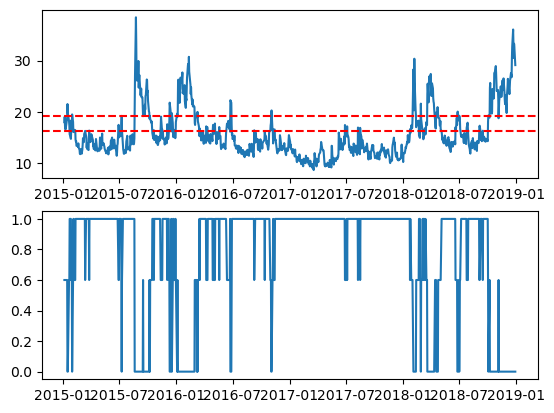

In [222]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(portfolio_df['Volatility'])
plt.axhline(16.25, color = 'red', linestyle = '--')
plt.axhline(19.2, color = 'red', linestyle = '--')
plt.subplot(2,1,2)
plt.plot(portfolio_df['w_ndq'])
plt.show()

In [223]:
portfolio_df.head()

,r_ndq,r_rf,Volatility,w_ndq,w_rf,r_portfolio,rf_rate
Date,,,,,,,
2015-01-05,-0.014669,0.006101,18.00,0.6,0.4,-0.006361,1.190476e-06
2015-01-06,-0.013408,0.006718,19.05,0.6,0.4,-0.005358,1.190476e-06
2015-01-07,0.012891,-0.000186,17.20,0.6,0.4,0.007660,1.190476e-06
2015-01-08,0.019140,-0.004079,16.61,0.6,0.4,0.009852,1.190476e-06
2015-01-09,-0.006583,0.004933,16.60,0.6,0.4,-0.001976,7.936508e-07


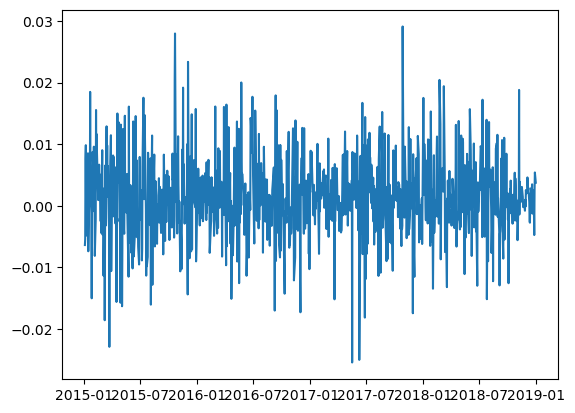

In [225]:
plt.plot(portfolio_df['r_portfolio'])

In [ ]:
portfolio_df.sum()

C:\Users\ingam\AppData\Local\Temp\ipykernel_36472\3742371718.py:1: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  portfolio_df.sum()


r_ndq              0.844094
r_rf               0.020161
Volatility     20038.430000
w_ndq           1169.000000
w_rf              87.000000
r_portfolio        1.170980
dtype: float64

Based on Sharpe:

In [ ]:
import numpy as np
import pandas as pd
from itertools import product

def calculate_average_sharpe(r, s):
    w_ndq = []
    w_rf = []
    for volatility in portfolio_df['Volatility']:
        if volatility > s:
            w_ndq.append(0)
            w_rf.append(1)
        elif volatility <= s and volatility > r:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        else:
            w_ndq.append(1)
            w_rf.append(0)
    portfolio_df['w_ndq'] = w_ndq
    portfolio_df['w_rf'] = w_rf
    portfolio_df['r_portfolio'] = portfolio_df['w_ndq'] * portfolio_df['r_ndq'] + portfolio_df['w_rf'] * portfolio_df['r_rf']
    portfolio_df['dgf_portfolio'] = 1 + portfolio_df['r_portfolio']
    #calculate monthly returns and stuff for sharpe:
    # Resample the data by month and calculate mean and standard deviation for specific columns
    monthly_stats = portfolio_df.resample('M').agg({
        'r_ndq': ['mean', 'std'],
        'r_rf': ['mean', 'std'],
        'r_portfolio': 'mean',
        'w_ndq': 'mean',
        'w_rf': 'mean'
        })


    # Flatten the MultiIndex in columns created by agg()
    monthly_stats.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in monthly_stats.columns.values]

    grouped = portfolio_df.resample('M')
    covariances = []
    for month in grouped:
        cov = np.cov(month[1]['r_ndq'], month[1]['r_rf'])[0,1]
        row = {'Date': month[0], 'covariance': cov}
        covariances.append(row)

    covariances = pd.DataFrame(covariances)
    covariances.set_index('Date', inplace=True)

    # Combine the results
    monthly_stats = pd.concat([monthly_stats, covariances], axis=1)
    monthly_stats['monthly_returns_portfolio'] = monthly_stats['dgf_portfolio_prod'] - 1
    #calculate standard deviation of the portfolio per month:

    monthly_stats['std_portfolio'] = np.sqrt(monthly_stats['w_ndq_mean']**2*monthly_stats['r_ndq_std']**2 + monthly_stats['w_rf_mean']**2*monthly_stats['r_rf_std']**2 + 2*monthly_stats['w_ndq_mean']*monthly_stats['w_rf_mean']*monthly_stats['covariance'])
    monthly_stats = monthly_stats.reset_index()
    monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date']).dt.to_period('M').dt.to_timestamp().dt.date
    monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date'])
    sharpe_df = pd.merge(monthly_stats, r_rf_df, on='Date', how='left')
    sharpe_df['risk_premium'] = sharpe_df['monthly_returns_portfolio'] - sharpe_df['monthly_rf']
    sharpe_df['sharpe_ratio'] = sharpe_df['risk_premium']/(sharpe_df['std_portfolio']*100)
    return np.average(sharpe_df['sharpe_ratio']), sharpe_df, portfolio_df

# Define ranges for r and s
r_values = np.linspace(5, 20, 21)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(6, 30, 21)  # from 10 to 20 in 0.5 increments

# Grid search
max_sharpe = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    if s > r:  # Ensure s is always greater than r
        average_sharpe, sharpe_df, portfolio_df1 = calculate_average_sharpe(r, s)
        if average_sharpe > max_sharpe:
            max_sharpe = average_sharpe
            sharpe_df = sharpe_df
            best_r, best_s = r, s
            portfolio_df = portfolio_df1

print(f'Best r: {best_r}, Best s: {best_s}, Maximized average Sharpe ratio (%): {max_sharpe*100}')


Best r: 14.0, Best s: 14.4, Maximized average Sharpe ratio (%): 4.30453554330433


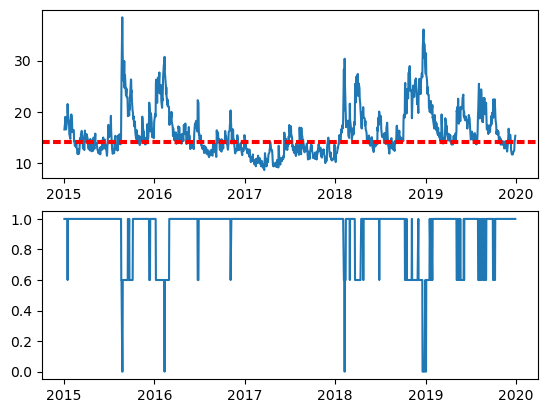

In [ ]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(portfolio_df['Volatility'])
plt.axhline(14, color = 'red', linestyle = '--')
plt.axhline(14.4, color = 'red', linestyle = '--')
plt.subplot(2,1,2)
plt.plot(portfolio_df['w_ndq'])
plt.show()

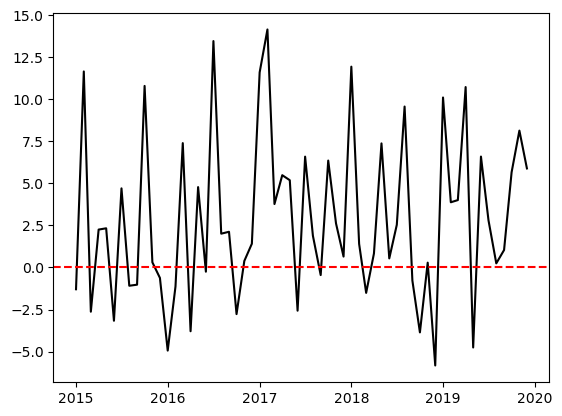

In [ ]:
plt.plot(sharpe_df['Date'], sharpe_df['sharpe_ratio']*100, color = 'black')
plt.axhline(0, color = 'red', linestyle = '--')

In [ ]:
sharpe_df['w_ndq_mean'].mean()

0.9298436291651394

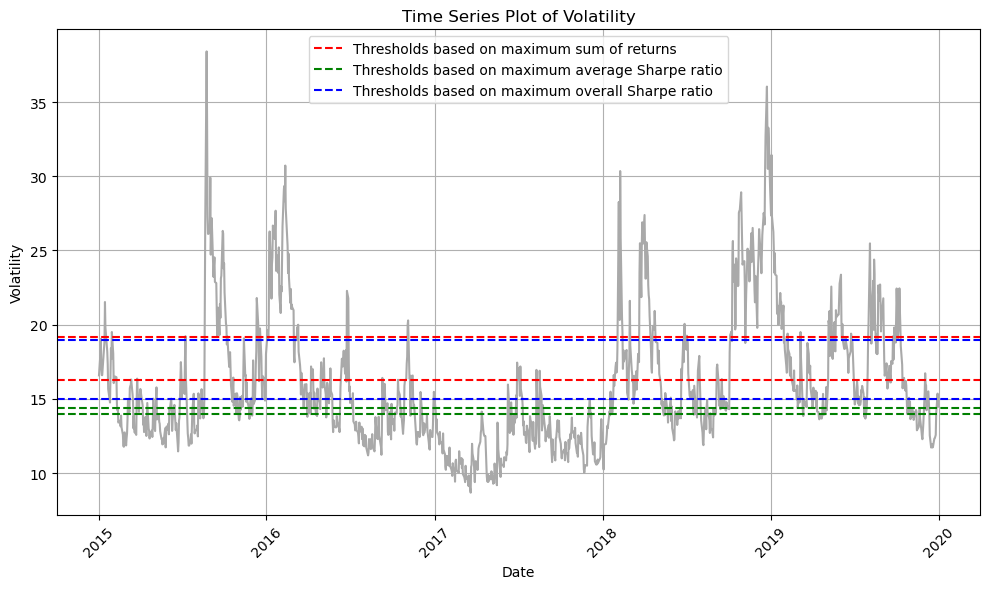

In [ ]:
# Plotting the Volatility over time
plt.figure(figsize=(10, 6))  # Setting the figure size
plt.plot(volatility_df['Date'], volatility_df['Price'], linestyle='-', color='darkgray')  # Plotting data
plt.axhline(16.25, color = 'red', linestyle = '--', label='Thresholds based on maximum sum of returns')
plt.axhline(19.2, color = 'red', linestyle = '--')
plt.axhline(14, color = 'green', linestyle = '--', label='Thresholds based on maximum average Sharpe ratio')
plt.axhline(14.4, color = 'green', linestyle = '--')
plt.axhline(15, color = 'blue', linestyle = '--', label='Thresholds based on maximum overall Sharpe ratio')
plt.axhline(19, color = 'blue', linestyle = '--')
plt.legend()
plt.title('Time Series Plot of Volatility')  # Adding a title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Volatility')  # Y-axis label
plt.grid(True)  # Adding a grid for better readability
plt.xticks(rotation=45)  # Rotating X-axis labels for better readability
plt.tight_layout()  # Adjusting the layout to make room for the rotated x-axis labels

# Displaying the plot
plt.show()

In [ ]:
sharpe_df['w_rf_mean'].mean()

0.07015637083486054

Next: do the exact same thing except use annualized sharpe ratios before averaging:

In [ ]:
import numpy as np
import pandas as pd
from itertools import product

def calculate_average_annualized_sharpe(r, s):
    w_ndq = []
    w_rf = []
    for volatility in portfolio_df['Volatility']:
        if volatility > s:
            w_ndq.append(0)
            w_rf.append(1)
        elif volatility <= s and volatility > r:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        else:
            w_ndq.append(1)
            w_rf.append(0)
    portfolio_df['w_ndq'] = w_ndq
    portfolio_df['w_rf'] = w_rf
    portfolio_df['r_portfolio'] = portfolio_df['w_ndq'] * portfolio_df['r_ndq'] + portfolio_df['w_rf'] * portfolio_df['r_rf']
    portfolio_df['dgf_portfolio'] = 1 + portfolio_df['r_portfolio']
    #calculate monthly returns and stuff for sharpe:
    # Resample the data by month and calculate mean and standard deviation for specific columns
    monthly_stats = portfolio_df.resample('M').agg({
        'r_ndq': ['mean', 'std'],
        'r_rf': ['mean', 'std'],
        'r_portfolio': 'mean',
        'dgf_portfolio': 'prod',
        'w_ndq': 'mean',
        'w_rf': 'mean'
        })


    # Flatten the MultiIndex in columns created by agg()
    monthly_stats.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in monthly_stats.columns.values]

    grouped = portfolio_df.resample('M')
    covariances = []
    for month in grouped:
        cov = np.cov(month[1]['r_ndq'], month[1]['r_rf'])[0,1]
        row = {'Date': month[0], 'covariance': cov}
        covariances.append(row)

    covariances = pd.DataFrame(covariances)
    covariances.set_index('Date', inplace=True)

    # Combine the results
    monthly_stats = pd.concat([monthly_stats, covariances], axis=1)
    monthly_stats['monthly_returns_portfolio'] = monthly_stats['dgf_portfolio_prod'] - 1
    #calculate standard deviation of the portfolio per month:

    monthly_stats['std_portfolio'] = np.sqrt(monthly_stats['w_ndq_mean']**2*monthly_stats['r_ndq_std']**2 + monthly_stats['w_rf_mean']**2*monthly_stats['r_rf_std']**2 + 2*monthly_stats['w_ndq_mean']*monthly_stats['w_rf_mean']*monthly_stats['covariance'])
    monthly_stats = monthly_stats.reset_index()
    monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date']).dt.to_period('M').dt.to_timestamp().dt.date
    monthly_stats['Date'] = pd.to_datetime(monthly_stats['Date'])
    sharpe_df = pd.merge(monthly_stats, r_rf_df, on='Date', how='left')
    sharpe_df['risk_premium'] = sharpe_df['monthly_returns_portfolio'] - sharpe_df['monthly_rf']
    sharpe_df['sharpe_ratio'] = sharpe_df['risk_premium']/(sharpe_df['std_portfolio']*100)
    return np.average(sharpe_df['sharpe_ratio'])*np.sqrt(12), sharpe_df

# Define ranges for r and s
r_values = np.linspace(5, 20, 21)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(6, 30, 21)  # from 10 to 20 in 0.5 increments

# Grid search
max_sharpe = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    if s > r:  # Ensure s is always greater than r
        average_annualized_sharpe, sharpe_df = calculate_average_annualized_sharpe(r, s)
        if average_annualized_sharpe > max_sharpe:
            max_sharpe = average_annualized_sharpe
            sharpe_df = sharpe_df
            best_r, best_s = r, s

print(f'Best r: {best_r}, Best s: {best_s}, Maximized average annualized Sharpe ratio (%): {max_sharpe}')


Best r: 14.0, Best s: 14.4, Maximized average annualized Sharpe ratio (%): 0.149113485279784


Other option: cumulative metric: sharpe ratio over entire period:

In [ ]:
# need mean risk free rate:
mean_rf = r_rf_df['monthly_rf'].mean()

In [ ]:
import numpy as np
import pandas as pd
from itertools import product

def calculate_overall_sharpe(r, s):
    w_ndq = []
    w_rf = []
    for volatility in portfolio_df['Volatility']:
        if volatility > s:
            w_ndq.append(0)
            w_rf.append(1)
        elif volatility <= s and volatility > r:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        else:
            w_ndq.append(1)
            w_rf.append(0)
    portfolio_df['w_ndq'] = w_ndq
    portfolio_df['w_rf'] = w_rf
    portfolio_df['r_portfolio'] = portfolio_df['w_ndq'] * portfolio_df['r_ndq'] + portfolio_df['w_rf'] * portfolio_df['r_rf']
    portfolio_df['dgf_portfolio'] = 1 + portfolio_df['r_portfolio']
    #calculate monthly returns and stuff for sharpe:
    # Resample the data by month and calculate mean and standard deviation for specific columns
    monthly_stats = portfolio_df.resample('M').agg({
        'r_ndq': ['mean', 'std'],
        'r_rf': ['mean', 'std'],
        'r_portfolio': 'mean',
        'dgf_portfolio': 'prod',
        'w_ndq': 'mean',
        'w_rf': 'mean'
        })


    # Flatten the MultiIndex in columns created by agg()
    monthly_stats.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in monthly_stats.columns.values]

    grouped = portfolio_df.resample('M')
    covariances = []
    for month in grouped:
        cov = np.cov(month[1]['r_ndq'], month[1]['r_rf'])[0,1]
        row = {'Date': month[0], 'covariance': cov}
        covariances.append(row)

    covariances = pd.DataFrame(covariances)
    covariances.set_index('Date', inplace=True)

    # Combine the results
    monthly_stats = pd.concat([monthly_stats, covariances], axis=1)
    monthly_stats['monthly_returns_portfolio'] = monthly_stats['dgf_portfolio_prod'] - 1
    risk_premium = monthly_stats['monthly_returns_portfolio'].mean() - mean_rf
    std_p = np.std(monthly_stats['monthly_returns_portfolio'])
    sharpe_ratio = risk_premium/std_p
    return sharpe_ratio

# Define ranges for r and s
r_values = np.linspace(10, 20, 51)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(11, 30, 96)  # from 10 to 20 in 0.5 increments

# Grid search
max_sharpe = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    if s > r:  # Ensure s is always greater than r
        overall_sharpe = calculate_overall_sharpe(r, s)
        if overall_sharpe > max_sharpe:
            max_sharpe = overall_sharpe
            best_r, best_s = r, s

print(f'Best r: {best_r}, Best s: {best_s}, Maximized overall Sharpe ratio (%): {max_sharpe*100}')


Best r: 15.0, Best s: 19.0, Maximized overall Sharpe ratio (%): 95.82730836513977


benchmark model gives overall sharpe: 22.90%
(have to change the calculations - not real results probably)

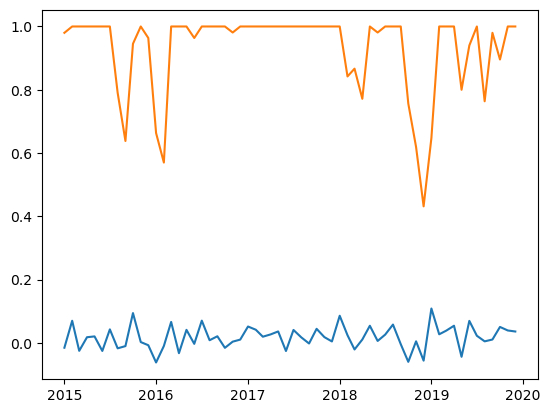

In [ ]:
plt.plot(sharpe_df['Date'], sharpe_df['monthly_returns_portfolio'])
plt.plot(sharpe_df['Date'], sharpe_df['w_ndq_mean'])

Sentiment stuff:

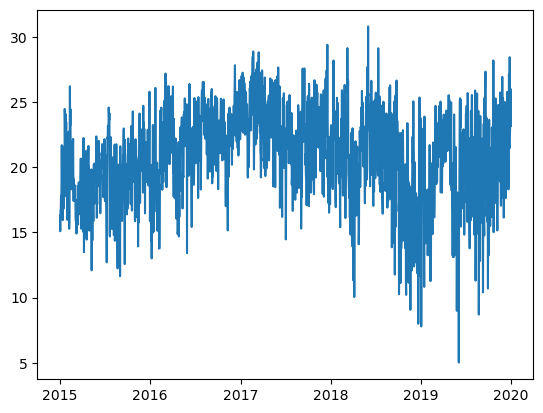

In [ ]:
plt.plot(sentiment_index_df['Date'], sentiment_index_df['sentiment_score']*100)

In [ ]:
portfolio_df_sent.tail()

,Date,r_ndq,r_rf,Volatility,w_ndq,w_rf,r_portfolio,rf_rate,sentiment_score,moving_average
993,2018-12-24,-0.024798,0.002519,36.04,0.0,1.0,0.002519,0.000098,0.143524,0.160255
994,2018-12-26,0.062439,-0.004735,30.50,0.0,1.0,-0.004735,0.000097,0.253396,0.162378
995,2018-12-27,0.003870,0.002525,33.27,0.0,1.0,0.002525,0.000096,0.163457,0.161059
996,2018-12-28,-0.000523,0.005424,32.54,0.0,1.0,0.005424,0.000095,0.148482,0.158562
997,2018-12-31,0.008433,0.003757,29.11,0.6,0.4,0.006563,0.000097,0.212255,0.155452


### Calculate sharpe based on sentiment index:

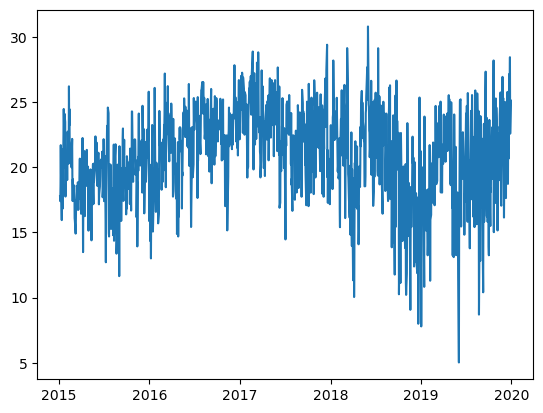

In [227]:
plt.plot(portfolio_df_sent['sentiment_score'])

In [369]:
price_df.set_index('Date', inplace=True)

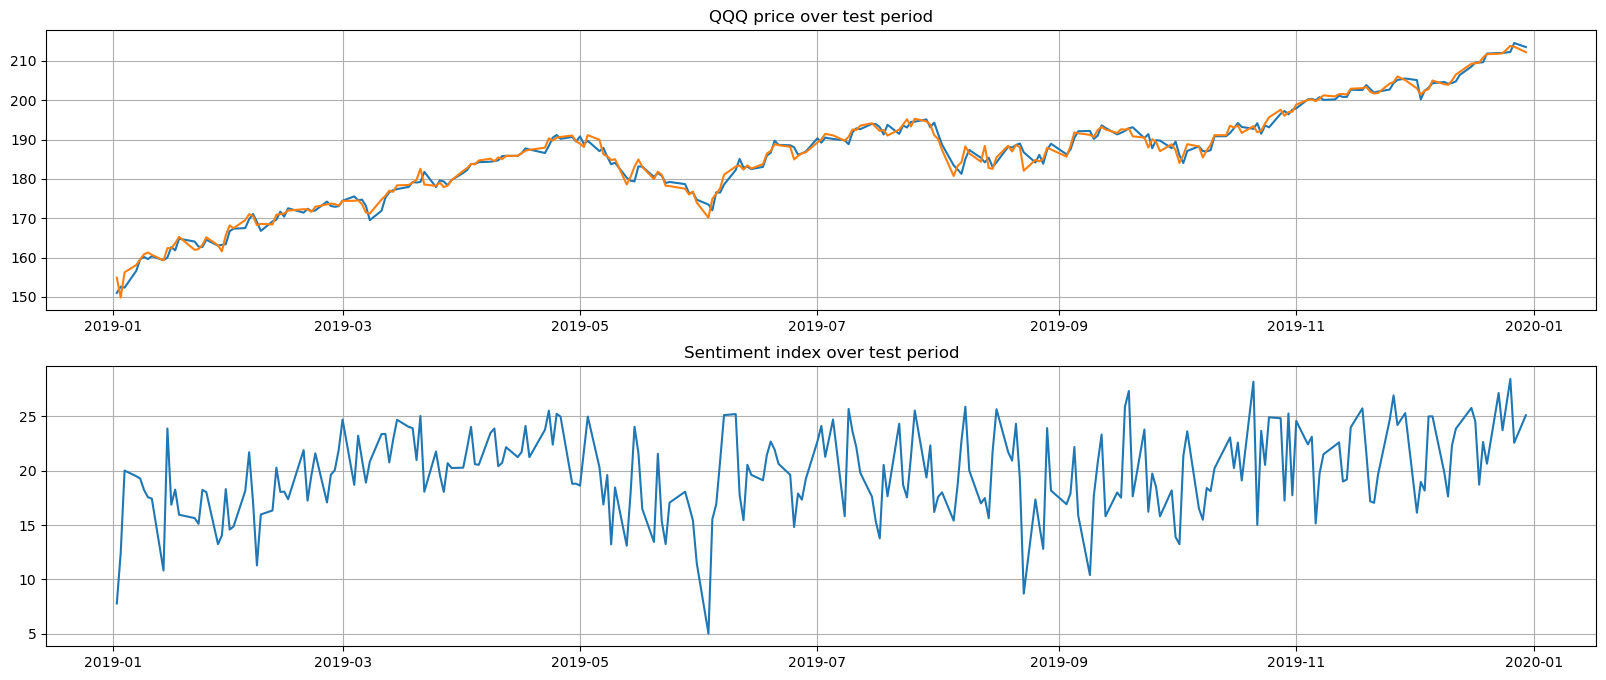

In [387]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.title('QQQ price over test period')
plt.plot(price_df['Open']['2019-01-01':])
plt.plot(price_df['Close']['2019-01-01':])
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(portfolio_df_sent['sentiment_score']['2019-01-01':])
plt.title('Sentiment index over test period')
plt.grid(True)
plt.show()

In [402]:
portfolio_df_sent['r_benchmark'] = portfolio_df_sent['r_ndq']*0.6 + portfolio_df_sent['r_rf']*0.4

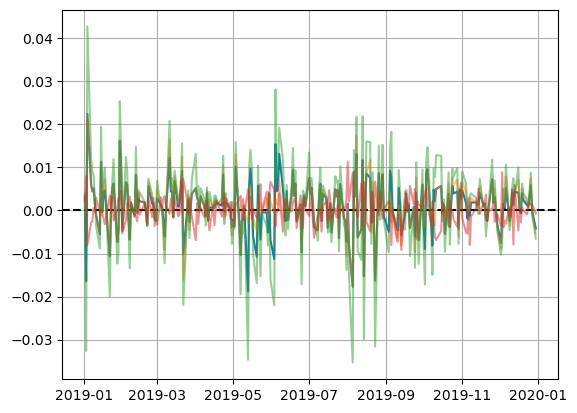

In [421]:
plt.plot(portfolio_df_sent['r_benchmark']['2019-01-01':])
plt.grid(True)
plt.axhline(0, color = 'black', linestyle='--')
plt.plot(portfolio_df_sent_test['r_portfolio'], alpha=0.5)
plt.plot(portfolio_df_sent_test['r_ndq'], alpha = 0.5)
plt.plot(portfolio_df_sent_test['r_rf'], alpha = 0.5)

In [423]:
range(window_size)

range(0, 60)

In [467]:
# exponentially decaying weights stuff:
# Define the window size and alpha for exponential decay
window_size = 20
alpha = 0.9

# Compute exponential weights
weights = np.array([alpha**(i) for i in range(window_size)])
weights = np.flip(weights)

# Normalize weights
weights /= weights.sum()

# Define the custom function to apply
def weighted_avg(values):
    return np.dot(values, weights)

# Define the custom function to calculate quantiles with weights
def weighted_quantile(values, quantile=0.5):
    # Ensure the values are sorted
    sorter = np.argsort(values)
    values_sorted = values[sorter]
    weights_sorted = weights[sorter]

    # Compute the cumulative sum of weights
    cumsum = np.cumsum(weights_sorted)

    # Find where the cumulative sum equals or exceeds the quantile
    return np.interp(quantile, cumsum, values_sorted)

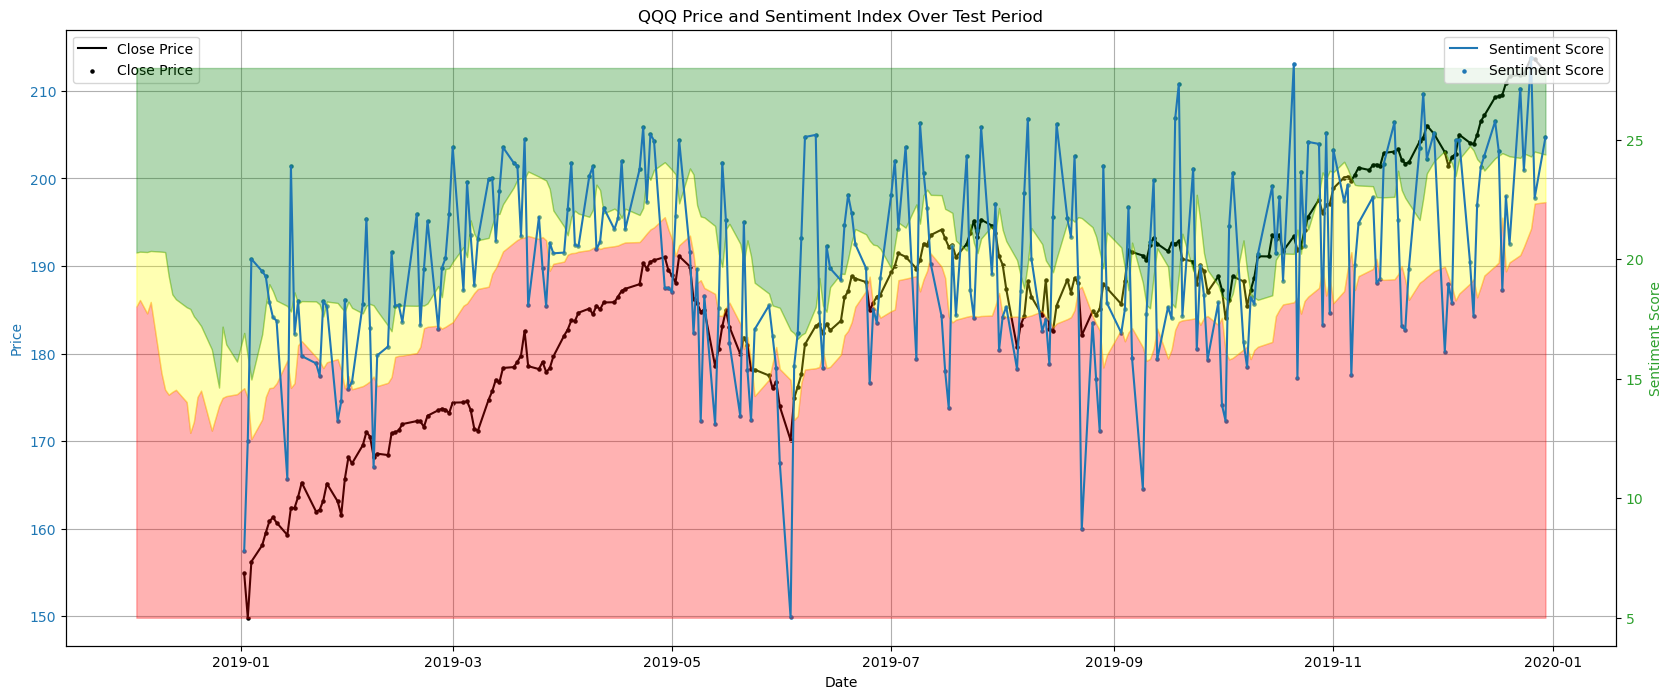

In [474]:
import matplotlib.pyplot as plt

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(20, 8))

# Plotting the price data on the first y-axis
ax1.set_xlabel('Date')  # Set the x-axis label
ax1.set_ylabel('Price', color='tab:blue')  # Set the y-axis label and color for the price data
#ax1.plot(price_df['Open']['2019-01-01':], color='tab:blue', label='Open Price')  # Plot the open prices
ax1.plot(price_df['Close']['2019-01-01':], color='black', label='Close Price')  # Plot the close prices
ax1.scatter(price_df['Close']['2019-01-01':].index, price_df['Close']['2019-01-01':], s=5, color='black', label='Close Price')  # Plot the close prices
ax1.tick_params(axis='y', labelcolor='tab:blue')  # Set the tick color for the y-axis
ax1.legend(loc='upper left')  # Place a legend in the upper left corner
ax1.grid(True)  # Enable grid
ax1.set_title('QQQ Price and Sentiment Index Over Test Period')  # Set title for the plot

# Creating a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Sentiment Score', color='tab:green')  # Set the y-axis label and color for the sentiment data
ax2.plot(portfolio_df_sent['sentiment_score']['2019-01-01':], color='tab:blue', label='Sentiment Score')  # Plot the sentiment score
ax2.scatter(portfolio_df_sent['sentiment_score']['2019-01-01':].index, portfolio_df_sent['sentiment_score']['2019-01-01':], s=5, color='tab:blue', label='Sentiment Score')  # Plot the sentiment score
ax2.tick_params(axis='y', labelcolor='tab:green')  # Set the tick color for the y-axis
ax2.legend(loc='upper right')  # Place a legend in the upper right corner
plt.fill_between(x = portfolio_df_sent['2018-11-01':].index, y1 = 5, y2 = portfolio_df_sent['2018-11-01':]['sentiment_score'].shift(1).rolling(20).apply(lambda x: weighted_quantile(x, quantile=0.33), raw=True), alpha = 0.3, color = 'red', label='Risk-off')
plt.fill_between(x = portfolio_df_sent['2018-11-01':].index, y1 = portfolio_df_sent['2018-11-01':]['sentiment_score'].shift(1).rolling(20).apply(lambda x: weighted_quantile(x, quantile=0.33), raw=True), y2 =portfolio_df_sent['2018-11-01':]['sentiment_score'].shift(1).rolling(20).apply(lambda x: weighted_quantile(x, quantile=0.66), raw=True), alpha = 0.3, color = 'yellow', label='Neutral')
plt.fill_between(x = portfolio_df_sent['2018-11-01':].index, y1 = portfolio_df_sent['2018-11-01':]['sentiment_score'].shift(1).rolling(20).apply(lambda x: weighted_quantile(x, quantile=0.66), raw=True), y2 = 28, alpha = 0.3, color = 'green', label='Risk-on')

# Show the plot
plt.show()


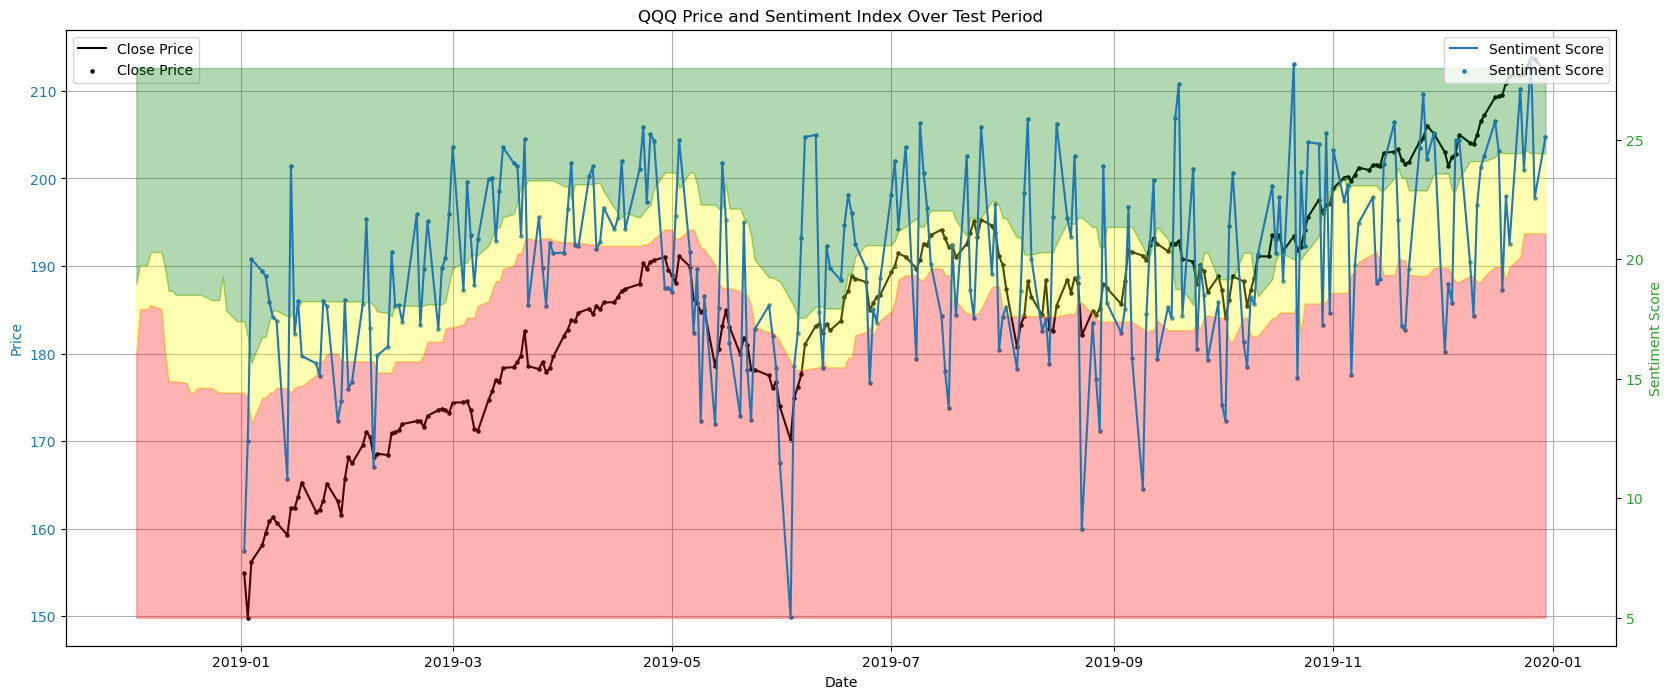

In [478]:
import matplotlib.pyplot as plt

# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(20, 8))

# Plotting the price data on the first y-axis
ax1.set_xlabel('Date')  # Set the x-axis label
ax1.set_ylabel('Price', color='tab:blue')  # Set the y-axis label and color for the price data
#ax1.plot(price_df['Open']['2019-01-01':], color='tab:blue', label='Open Price')  # Plot the open prices
ax1.plot(price_df['Close']['2019-01-01':], color='black', label='Close Price')  # Plot the close prices
ax1.scatter(price_df['Close']['2019-01-01':].index, price_df['Close']['2019-01-01':], s=5, color='black', label='Close Price')  # Plot the close prices
ax1.tick_params(axis='y', labelcolor='tab:blue')  # Set the tick color for the y-axis
ax1.legend(loc='upper left')  # Place a legend in the upper left corner
ax1.grid(True)  # Enable grid
ax1.set_title('QQQ Price and Sentiment Index Over Test Period')  # Set title for the plot

# Creating a second y-axis that shares the same x-axis
ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Sentiment Score', color='tab:green')  # Set the y-axis label and color for the sentiment data
ax2.plot(portfolio_df_sent['sentiment_score']['2019-01-01':], color='tab:blue', label='Sentiment Score')  # Plot the sentiment score
ax2.scatter(portfolio_df_sent['sentiment_score']['2019-01-01':].index, portfolio_df_sent['sentiment_score']['2019-01-01':], s=5, color='tab:blue', label='Sentiment Score')  # Plot the sentiment score
ax2.tick_params(axis='y', labelcolor='tab:green')  # Set the tick color for the y-axis
ax2.legend(loc='upper right')  # Place a legend in the upper right corner
plt.fill_between(x = portfolio_df_sent['2018-11-01':].index, y1 = 5, y2 = portfolio_df_sent['2018-11-01':]['sentiment_score'].shift(1).rolling(20).quantile(0.33), alpha = 0.3, color = 'red', label='Risk-off')
plt.fill_between(x = portfolio_df_sent['2018-11-01':].index, y1 = portfolio_df_sent['2018-11-01':]['sentiment_score'].shift(1).rolling(20).quantile(0.33), y2 =portfolio_df_sent['2018-11-01':]['sentiment_score'].shift(1).rolling(20).quantile(0.66), alpha = 0.3, color = 'yellow', label='Neutral')
plt.fill_between(x = portfolio_df_sent['2018-11-01':].index, y1 = portfolio_df_sent['2018-11-01':]['sentiment_score'].shift(1).rolling(20).quantile(0.66), y2 = 28, alpha = 0.3, color = 'green', label='Risk-on')

# Show the plot
plt.show()


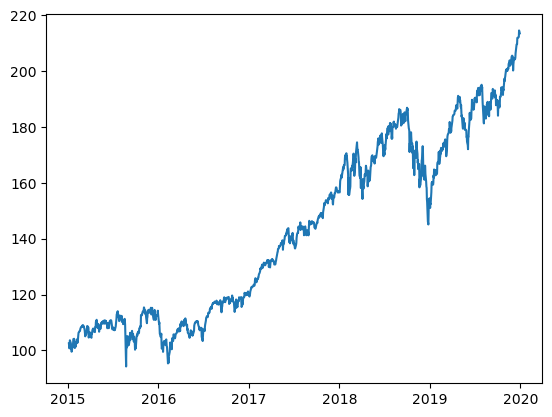

In [479]:
plt.plot(price_df['Open'])

In [389]:
df = pd.merge(price_df['Adj Close']['2019-01-01':], portfolio_df_sent['sentiment_score']['2019-01-01':], on = 'Date', how = 'inner')

In [391]:
import seaborn as sns
df.corr()

,Adj Close,sentiment_score
Adj Close,1.000000,0.424441
sentiment_score,0.424441,1.000000


In [228]:
portfolio_df_sent['moving_average_10day'] = portfolio_df_sent['sentiment_score'].rolling(window = 10).mean()

In [229]:
portfolio_df_sent['moving_average_10day_lag'] = portfolio_df_sent['moving_average_10day'].shift(1)

In [230]:
portfolio_df_sent['moving_average_5day'] = portfolio_df_sent['sentiment_score'].rolling(window = 5).mean()

In [231]:
portfolio_df_sent['moving_average_3day'] = portfolio_df_sent['sentiment_score'].rolling(window = 3).mean()

In [264]:
portfolio_df_sent['moving_average_7day'] = portfolio_df_sent['sentiment_score'].rolling(window = 7).mean()

In [265]:
#want to just look at the training period for threshold optimization
#and then just at the test period for calculating the sharpe
portfolio_df_sent_train = portfolio_df_sent[:'2019-01-01'].copy()
portfolio_df_sent_test = portfolio_df_sent['2019-01-01':].copy()

In [278]:
# just choosing random values for s (20) and r (15) here, would be better to optimize those as well!
def overall_sharpe_sentiment(r, s):
    w_ndq = []
    w_rf = []
    for score in portfolio_df_sent_train['moving_average_10day']:
        if score > s:
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= s and score > r:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        else: #elif score <= r:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    portfolio_df_sent_train['w_ndq'] = w_ndq
    portfolio_df_sent_train['w_rf'] = w_rf
    portfolio_df_sent_train['r_portfolio'] = portfolio_df_sent_train['w_ndq'] * portfolio_df_sent_train['r_ndq'] + portfolio_df_sent_train['w_rf'] * portfolio_df_sent_train['r_rf']
    portfolio_df_sent_train['excess return'] = portfolio_df_sent_train['r_portfolio'] - portfolio_df_sent_train['rf_rate']
    mean_return_portfolio = portfolio_df_sent_train['r_portfolio'].mean()
    std_portfolio = np.std(portfolio_df_sent_train['excess return'])
    mean_risk_free_rate = portfolio_df_sent_train['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_portfolio
    return sharpe_ratio


In [279]:
from itertools import product
# Define ranges for r and s
r_values = np.linspace(5, 30, 21)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(6, 40, 21)  # from 10 to 20 in 0.5 increments

# Grid search
max_sharpe = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    #print('first loop', r, s)
    if s > r:  # Ensure s is always greater than r
        sharpe = overall_sharpe_sentiment(r, s)
        #print(sharpe)
        if sharpe > max_sharpe:
            #print(r, s)
            max_sharpe = sharpe
            best_r, best_s = r, s

print(f'Best r: {best_r}, Best s: {best_s}, Maximized Overall Sharpe: {max_sharpe*100}')

Best r: 22.5, Best s: 23.0, Maximized Overall Sharpe: 11.015830990911581


In [235]:
portfolio_df_sent_train['moving_average_10day'].shape

(998,)

In [356]:
def overall_sharpe_sentiment_calc(sentiment):
    w_ndq = []
    w_rf = []
    for score in sentiment:
        if score > 23:
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= 2 and score > -20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= -20:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    portfolio_df_sent_test['w_ndq'] = w_ndq
    portfolio_df_sent_test['w_rf'] = w_rf
    portfolio_df_sent_test['r_portfolio'] = portfolio_df_sent_test['w_ndq'] * portfolio_df_sent_test['r_ndq'] + portfolio_df_sent_test['w_rf'] * portfolio_df_sent_test['r_rf']
    portfolio_df_sent_test['excess returns'] = portfolio_df_sent_test['r_portfolio'] - portfolio_df_sent_test['rf_rate']
    portfolio_df_sent_test['trading day'] = (portfolio_df_sent_test['w_ndq'] != portfolio_df_sent_test['w_ndq'].shift(1)).astype(int)
    mean_return_portfolio = portfolio_df_sent_test['r_portfolio'].mean()
    std_excess = np.std(portfolio_df_sent_test['excess returns'])
    mean_risk_free_rate = portfolio_df_sent_test['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_excess
    return sharpe_ratio

In [415]:
portfolio_df_sent_rolling = portfolio_df_sent['moving_average_10day']['2018-10-01':]

In [416]:
def overall_sharpe_sentiment_precentiles(sentiment):
    w_ndq = []
    w_rf = []

    upper = portfolio_df_sent_rolling.shift(1).rolling(60, min_periods = 1).quantile(0.8)
    lower = portfolio_df_sent_rolling.shift(1).rolling(60, min_periods = 1).quantile(0.2)
    test_sent = sentiment['2019-01-01':]
    for i in test_sent.index:
        score = sentiment[i]
        if score > upper[i]: #23: changing to see if it improves
            w_ndq.append(0.8)
            w_rf.append(0.2)
        elif score <= upper[i] and score > lower[i]: # was 20:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        elif score <= lower[i]:
            w_ndq.append(0.2)
            w_rf.append(0.8)
    portfolio_df_sent_test['w_ndq'] = w_ndq
    portfolio_df_sent_test['w_rf'] = w_rf
    portfolio_df_sent_test['r_portfolio'] = portfolio_df_sent_test['w_ndq'] * portfolio_df_sent_test['r_ndq'] + portfolio_df_sent_test['w_rf'] * portfolio_df_sent_test['r_rf']
    portfolio_df_sent_test['excess returns'] = portfolio_df_sent_test['r_portfolio'] - portfolio_df_sent_test['rf_rate']
    portfolio_df_sent_test['trading day'] = (portfolio_df_sent_test['w_ndq'] != portfolio_df_sent_test['w_ndq'].shift(1)).astype(int)
    mean_return_portfolio = portfolio_df_sent_test['r_portfolio'].mean()
    std_excess = np.std(portfolio_df_sent_test['excess returns'])
    mean_risk_free_rate = portfolio_df_sent_test['rf_rate'].mean()
    sharpe_ratio = (mean_return_portfolio - mean_risk_free_rate)/std_excess
    return sharpe_ratio, upper, lower

In [417]:
overall_sharpe_sentiment_precentiles(portfolio_df_sent_test['moving_average_10day'])

(0.20140377554675545,
 Date
 2018-10-01          NaN
 2018-10-02    21.957302
 2018-10-03    21.920370
 2018-10-04    22.013974
 2018-10-05    21.995083
                 ...    
 2019-12-23    22.019343
 2019-12-24    22.041237
 2019-12-26    22.097606
 2019-12-27    22.145484
 2019-12-30    22.197875
 Name: moving_average_10day, Length: 310, dtype: float64,
 Date
 2018-10-01          NaN
 2018-10-02    21.957302
 2018-10-03    21.809574
 2018-10-04    21.846506
 2018-10-05    21.274417
                 ...    
 2019-12-23    19.916878
 2019-12-24    19.916878
 2019-12-26    19.916878
 2019-12-27    19.916878
 2019-12-30    19.916878
 Name: moving_average_10day, Length: 310, dtype: float64)

In [357]:
overall_sharpe_sentiment_calc(portfolio_df_sent_test['lag_sentiment'])

0.15733254675703132

In [358]:
portfolio_df_sent_test['trading day'].sum()

89

In [256]:
portfolio_df_sent_test.shape

(249, 16)

So using just the lag of the sentiment gives better returns than using the benchmark portfolio...

In [408]:
overall_sharpe_sentiment_calc(portfolio_df_sent_test['sentiment_score'])

0.22135221091563087

In [110]:
#overall_sharpe_sentiment_calc(portfolio_df_sent_test['moving_average'])

KeyError: 'moving_average'

In [360]:
overall_sharpe_sentiment_calc(portfolio_df_sent_test['moving_average_5day'])

0.15810288629864613

In [361]:
overall_sharpe_sentiment_calc(portfolio_df_sent_test['moving_average_7day'])

0.1437473575244822

In [362]:
portfolio_df_sent_test['trading day'].sum()

22

In [363]:
overall_sharpe_sentiment_calc(portfolio_df_sent_test['moving_average_3day'])

0.16880428580620233

In [364]:
overall_sharpe_sentiment_calc(portfolio_df_sent_test['moving_average_10day'])

0.16373558732932839

In [365]:
portfolio_df_sent_test['trading day'].sum()

22

In [366]:
overall_sharpe_sentiment_calc(portfolio_df_sent_test['moving_average_10day_lag'])

0.13450098511260541

In [262]:
portfolio_df_sent_test['trading day'].sum()

25

<Axes: xlabel='Date'>

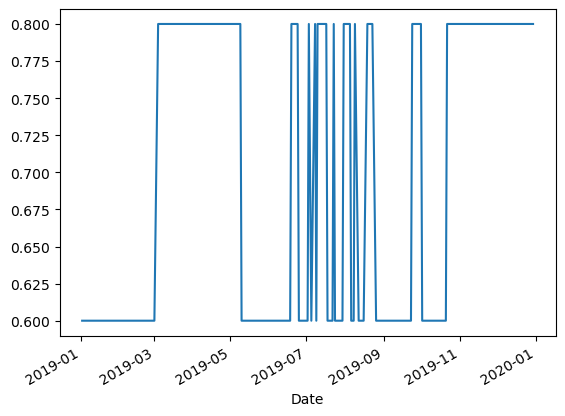

In [367]:
portfolio_df_sent_test['w_ndq'].plot()

<Axes: xlabel='Date'>

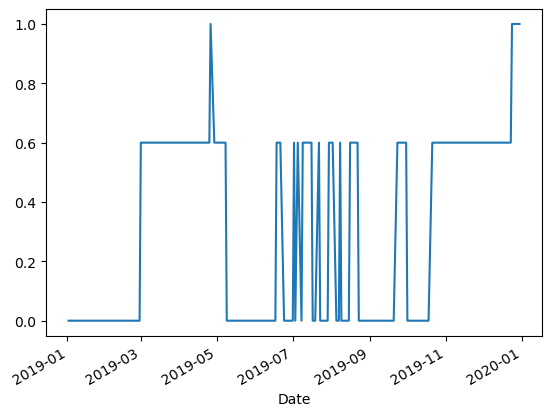

In [58]:
portfolio_df_sent_test['w_ndq'].plot()

<Axes: xlabel='Date'>

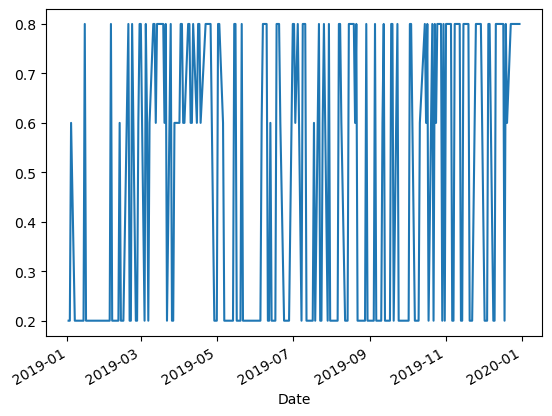

In [83]:
portfolio_df_sent_test['w_ndq'].plot()

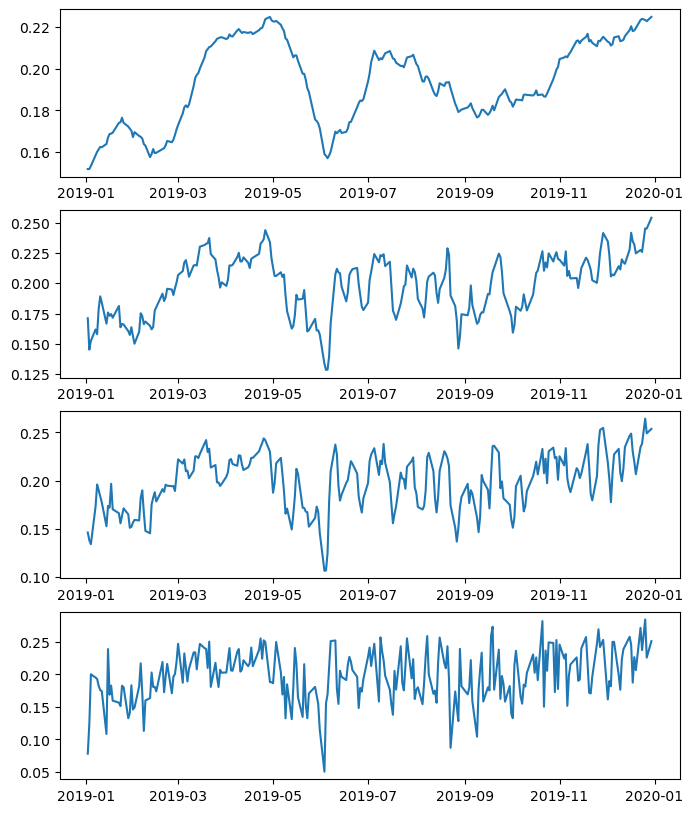

In [52]:
plt.figure(figsize=(8,10))
plt.subplot(4,1,1)
plt.plot(portfolio_df_sent_test['moving_average'])
plt.subplot(4,1,2)
plt.plot(portfolio_df_sent_test['moving_average_5day'])
plt.subplot(4,1,3)
plt.plot(portfolio_df_sent_test['moving_average_3day'])
plt.subplot(4,1,4)
plt.plot(portfolio_df_sent_test['sentiment_score'])

Text(17250, 28, 'Risk-on')

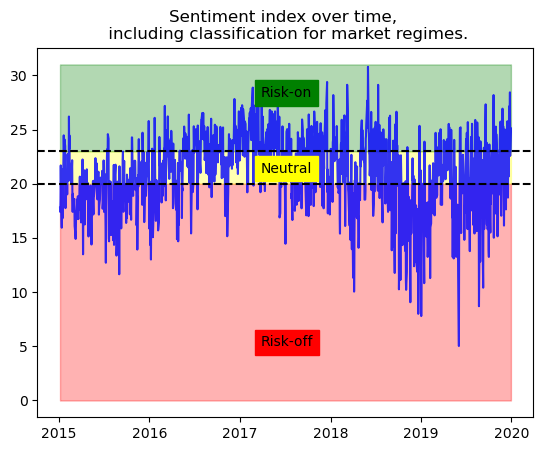

In [246]:
plt.plot(portfolio_df_sent['sentiment_score'], color = 'blue', alpha = 0.8)
plt.axhline(20, color = 'black', linestyle='--')
plt.axhline(23, color = 'black', linestyle='--')
plt.title('Sentiment index over time, \n including classification for market regimes.')
plt.fill_between(x = portfolio_df_sent.index, y1 = 20, alpha = 0.3, color = 'red')
plt.fill_between(x = portfolio_df_sent.index, y1 = 20, y2 = 23, alpha = 0.3, color = 'yellow')
plt.fill_between(x = portfolio_df_sent.index, y1 = 23, y2 = 31, alpha = 0.3, color = 'green')
plt.text(17250, 5, 'Risk-off', backgroundcolor = 'red')
plt.text(17250, 21, 'Neutral', backgroundcolor = 'yellow')
plt.text(17250, 28, 'Risk-on', backgroundcolor = 'green')

In [161]:
import numpy as np
import pandas as pd
from itertools import product

def calculate_total_return_sentiment(r, s):
    w_ndq = []
    w_rf = []
    for sentiment in portfolio_df_sent['sentiment_score']*100:
        if sentiment < r:
            w_ndq.append(0)
            w_rf.append(1)
        elif sentiment > r and sentiment <= s:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        else:
            w_ndq.append(1)
            w_rf.append(0)
    portfolio_df_sent['w_ndq'] = w_ndq
    portfolio_df_sent['w_rf'] = w_rf
    portfolio_df_sent['r_portfolio'] = portfolio_df_sent['w_ndq'] * portfolio_df_sent['r_ndq'] + portfolio_df_sent['w_rf'] * portfolio_df_sent['r_rf']
    return portfolio_df_sent['r_portfolio'].sum(), portfolio_df_sent

# Define ranges for r and s
r_values = np.linspace(5, 20, 21)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(6, 30, 21)  # from 10 to 20 in 0.5 increments

# Grid search
max_return = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    if s > r:  # Ensure s is always greater than r
        total_return, portfolio_df2 = calculate_total_return_sentiment(r, s)
        if total_return > max_return:
            max_return = total_return
            best_r, best_s = r, s
            portfolio_df_sent = portfolio_df2

print(f'Best r: {best_r}, Best s: {best_s}, Maximized Total Return: {max_return}')


Best r: 18.5, Best s: 19.2, Maximized Total Return: 2.907742436682424


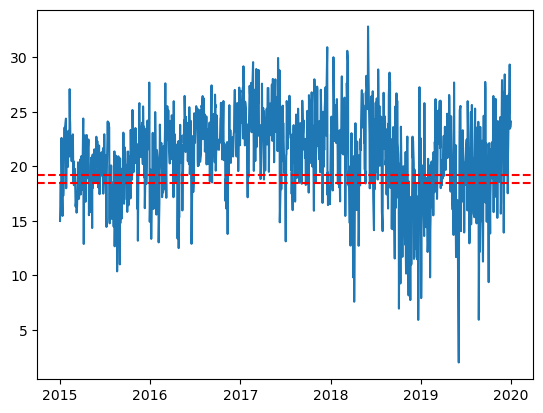

In [126]:
plt.plot(sentiment_index_log_weighed_df['Date'], sentiment_index_log_weighed_df['sentiment_score']*100)
plt.axhline(18.5, color = 'red', linestyle = '--')
plt.axhline(19.2, color = 'red', linestyle = '--')

sentiment lag 1:

In [143]:
sentiment_index_log_weighed_df['sentiment_lag1'] = sentiment_index_log_weighed_df['sentiment_score'].shift(1)
sentiment_index_log_weighed_df.dropna(inplace=True)

In [157]:
portfolio_df_sent_lag1 = pd.merge(portfolio_df, sentiment_index_log_weighed_df, on='Date', how='inner')

In [159]:
portfolio_df_sent_lag1['sentiment_lag1'] = portfolio_df_sent_lag1['sentiment_lag1']*100

In [162]:
import numpy as np
import pandas as pd
from itertools import product

def calculate_total_return_sentimentlag(r, s):
    w_ndq = []
    w_rf = []
    for sentiment in portfolio_df_sent_lag1['sentiment_lag1']:
        if sentiment < r:
            w_ndq.append(0)
            w_rf.append(1)
        elif sentiment > r and sentiment <= s:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        else:
            w_ndq.append(1)
            w_rf.append(0)
    portfolio_df_sent_lag1['w_ndq'] = w_ndq
    portfolio_df_sent_lag1['w_rf'] = w_rf
    portfolio_df_sent_lag1['r_portfolio'] = portfolio_df_sent_lag1['w_ndq'] * portfolio_df_sent_lag1['r_ndq'] + portfolio_df_sent_lag1['w_rf'] * portfolio_df_sent_lag1['r_rf']
    return portfolio_df_sent_lag1['r_portfolio'].sum(), portfolio_df_sent_lag1

# Define ranges for r and s
r_values = np.linspace(5, 20, 21)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(6, 30, 21)  # from 10 to 20 in 0.5 increments

# Grid search
max_return = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    if s > r:  # Ensure s is always greater than r
        total_return, portfolio_df2 = calculate_total_return_sentimentlag(r, s)
        if total_return > max_return:
            max_return = total_return
            best_r, best_s = r, s
            portfolio_df_sent_lag1 = portfolio_df2

print(f'Best r: {best_r}, Best s: {best_s}, Maximized Total Return: {max_return}')


Best r: 11.0, Best s: 20.4, Maximized Total Return: 0.7969389898751713


In [163]:
calculate_total_return_sentimentlag(5,6)

(0.6979408251061976,
            Date     r_ndq      r_rf  Volatility  w_ndq  w_rf  r_portfolio  \
 0    2015-01-05 -0.016513 -0.004607       18.00    1.0   0.0    -0.016513   
 1    2015-01-06 -0.012121 -0.000857       19.05    1.0   0.0    -0.012121   
 2    2015-01-07  0.011890  0.002806       17.20    1.0   0.0     0.011890   
 3    2015-01-08  0.019178 -0.003662       16.61    1.0   0.0     0.019178   
 4    2015-01-09 -0.006452 -0.003726       16.60    1.0   0.0    -0.006452   
 ...         ...       ...       ...         ...    ...   ...          ...   
 1251 2019-12-23  0.002017 -0.001716       12.34    1.0   0.0     0.002017   
 1252 2019-12-24  0.000402 -0.000312       12.36    1.0   0.0     0.000402   
 1253 2019-12-26  0.009017 -0.002179       12.58    1.0   0.0     0.009017   
 1254 2019-12-27 -0.000835  0.001011       14.03    1.0   0.0    -0.000835   
 1255 2019-12-30 -0.007008  0.000856       15.36    1.0   0.0    -0.007008   
 
       dgf_portfolio  sentiment_score  se

In [150]:
portfolio_df_sent_lag1.head()

,Date,r_ndq,r_rf,Volatility,w_ndq,w_rf,r_portfolio,dgf_portfolio,sentiment_score,sentiment_lag1
0,2015-01-05,-0.016513,-0.004607,18.00,0.0,1.0,-0.004607,0.983487,0.185542,0.149896
1,2015-01-06,-0.012121,-0.000857,19.05,0.0,1.0,-0.000857,0.987879,0.165909,0.185542
2,2015-01-07,0.011890,0.002806,17.20,0.0,1.0,0.002806,1.011890,0.182038,0.165909
3,2015-01-08,0.019178,-0.003662,16.61,0.0,1.0,-0.003662,1.019178,0.226006,0.182038
4,2015-01-09,-0.006452,-0.003726,16.60,0.6,0.4,-0.005361,0.993548,0.203986,0.226006


In [168]:
import numpy as np
import pandas as pd
from itertools import product

def calculate_sharpe_sentimentlag(r, s):
    w_ndq = []
    w_rf = []
    for sentiment in portfolio_df_sent_lag1['sentiment_lag1']:
        if sentiment < r:
            w_ndq.append(0)
            w_rf.append(1)
        elif sentiment > r and sentiment <= s:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        else:
            w_ndq.append(1)
            w_rf.append(0)
    portfolio_df_sent_lag1['w_ndq'] = w_ndq
    portfolio_df_sent_lag1['w_rf'] = w_rf
    portfolio_df_sent_lag1['r_portfolio'] = portfolio_df_sent_lag1['w_ndq'] * portfolio_df_sent_lag1['r_ndq'] + portfolio_df_sent_lag1['w_rf'] * portfolio_df_sent_lag1['r_rf']
    portfolio_df_sent_lag1['dgf_portfolio'] = 1 + portfolio_df_sent_lag1['r_portfolio']
    #calculate monthly returns and stuff for sharpe:
    # Resample the data by month and calculate mean and standard deviation for specific columns
    #portfolio_df_sent_lag1.set_index('Date', inplace=True)
    monthly_stats = portfolio_df_sent_lag1.resample('M').agg({
        'r_ndq': ['mean', 'std'],
        'r_rf': ['mean', 'std'],
        'r_portfolio': 'mean',
        'dgf_portfolio': 'prod',
        'w_ndq': 'mean',
        'w_rf': 'mean'
        })


    # Flatten the MultiIndex in columns created by agg()
    monthly_stats.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in monthly_stats.columns.values]
    grouped = portfolio_df_sent_lag1.resample('M')
    covariances = []
    for month in grouped:
        cov = np.cov(month[1]['r_ndq'], month[1]['r_rf'])[0,1]
        row = {'Date': month[0], 'covariance': cov}
        covariances.append(row)

    covariances = pd.DataFrame(covariances)
    covariances.set_index('Date', inplace=True)

    # Combine the results
    monthly_stats = pd.concat([monthly_stats, covariances], axis=1)
    monthly_stats['monthly_returns_portfolio'] = monthly_stats['dgf_portfolio_prod'] - 1
    risk_premium = monthly_stats['monthly_returns_portfolio'].mean() - mean_rf
    std_p = np.std(monthly_stats['monthly_returns_portfolio'])
    sharpe_ratio = risk_premium/std_p
    return sharpe_ratio


# Define ranges for r and s
r_values = np.linspace(10, 20, 51)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(11, 30, 96)  # from 10 to 20 in 0.5 increments

# Grid search
max_sharpe = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    if s > r:  # Ensure s is always greater than r
        overall_sharpe = calculate_sharpe_sentimentlag(r, s)
        if overall_sharpe > max_sharpe:
            max_sharpe = overall_sharpe
            best_r, best_s = r, s

print(f'Best r: {best_r}, Best s: {best_s}, Maximized overall Sharpe ratio (%): {max_sharpe*100}')


Best r: 15.8, Best s: 21.4, Maximized overall Sharpe ratio (%): 41.78104006042961


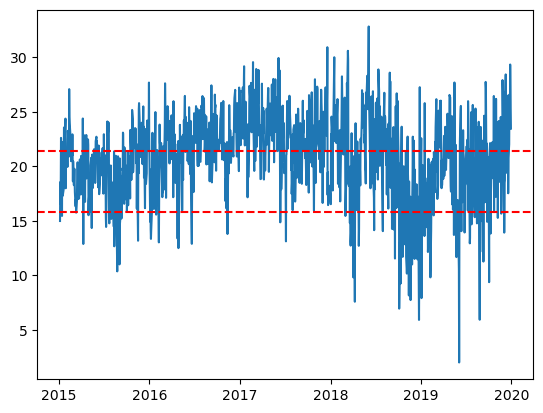

In [171]:
plt.plot(portfolio_df_sent_lag1['sentiment_lag1'])
plt.axhline(15.8, color = 'red', linestyle = '--')
plt.axhline(21.4, color = 'red', linestyle = '--')

-----------------------------------------------------------------
returns of just nasdaq:

In [164]:
portfolio_df_sent_lag1['r_ndq'].sum()

0.7221820610265333

In [172]:
sentiment_index_log_weighed_df = pd.read_excel('https://raw.githubusercontent.com/inga-maria01/master_thesis/main/index/sentiment_index_log_label_weighted.xlsx')
sentiment_index_log_weighed_df.rename(columns={'date':'Date'}, inplace=True)
sentiment_index_log_weighed_df.head()

,Date,sentiment_score
0,2015-01-02,0.189050
1,2015-01-05,0.237303
2,2015-01-06,0.222848
3,2015-01-07,0.265068
4,2015-01-08,0.346323


In [174]:
portfolio_df_sent = pd.merge(portfolio_df, sentiment_index_log_weighed_df, on='Date', how='inner')

sentiment_index_log_weighed_df['sentiment_lag1'] = sentiment_index_log_weighed_df['sentiment_score'].shift(1)
sentiment_index_log_weighed_df.dropna(inplace=True)

portfolio_df_sent_lag1 = pd.merge(portfolio_df, sentiment_index_log_weighed_df, on='Date', how='inner')

portfolio_df_sent_lag1['sentiment_lag1'] = portfolio_df_sent_lag1['sentiment_lag1']*100

In [183]:
import numpy as np
import pandas as pd
from itertools import product

def calculate_total_return_sentimentlag(r, s):
    w_ndq = []
    w_rf = []
    for sentiment in portfolio_df_sent_lag1['sentiment_lag1']:
        if sentiment < r:
            w_ndq.append(0)
            w_rf.append(1)
        elif sentiment > r and sentiment <= s:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        else:
            w_ndq.append(1)
            w_rf.append(0)
    portfolio_df_sent_lag1['w_ndq'] = w_ndq
    portfolio_df_sent_lag1['w_rf'] = w_rf
    portfolio_df_sent_lag1['r_portfolio'] = portfolio_df_sent_lag1['w_ndq'] * portfolio_df_sent_lag1['r_ndq'] + portfolio_df_sent_lag1['w_rf'] * portfolio_df_sent_lag1['r_rf']
    return portfolio_df_sent_lag1['r_portfolio'].sum(), portfolio_df_sent_lag1

# Define ranges for r and s
r_values = np.linspace(10, 45, 71)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(11, 50, 79)  # from 10 to 20 in 0.5 increments

# Grid search
max_return = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    if s > r:  # Ensure s is always greater than r
        total_return, portfolio_df2 = calculate_total_return_sentimentlag(r, s)
        if total_return > max_return:
            max_return = total_return
            best_r, best_s = r, s
            portfolio_df_sent_lag1 = portfolio_df2

print(f'Best r: {best_r}, Best s: {best_s}, Maximized Total Return: {max_return}')


Best r: 14.5, Best s: 15.0, Maximized Total Return: 0.8386469308749305


In [181]:
import numpy as np
import pandas as pd
from itertools import product

def calculate_sharpe_sentimentlag(r, s):
    w_ndq = []
    w_rf = []
    for sentiment in portfolio_df_sent_lag1['sentiment_lag1']:
        if sentiment < r:
            w_ndq.append(0)
            w_rf.append(1)
        elif sentiment > r and sentiment <= s:
            w_ndq.append(0.6)
            w_rf.append(0.4)
        else:
            w_ndq.append(1)
            w_rf.append(0)
    portfolio_df_sent_lag1['w_ndq'] = w_ndq
    portfolio_df_sent_lag1['w_rf'] = w_rf
    portfolio_df_sent_lag1['r_portfolio'] = portfolio_df_sent_lag1['w_ndq'] * portfolio_df_sent_lag1['r_ndq'] + portfolio_df_sent_lag1['w_rf'] * portfolio_df_sent_lag1['r_rf']
    portfolio_df_sent_lag1['dgf_portfolio'] = 1 + portfolio_df_sent_lag1['r_portfolio']
    #calculate monthly returns and stuff for sharpe:
    # Resample the data by month and calculate mean and standard deviation for specific columns
    #portfolio_df_sent_lag1.set_index('Date', inplace=True)
    monthly_stats = portfolio_df_sent_lag1.resample('M').agg({
        'r_ndq': ['mean', 'std'],
        'r_rf': ['mean', 'std'],
        'r_portfolio': 'mean',
        'dgf_portfolio': 'prod',
        'w_ndq': 'mean',
        'w_rf': 'mean'
        })


    # Flatten the MultiIndex in columns created by agg()
    monthly_stats.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in monthly_stats.columns.values]
    grouped = portfolio_df_sent_lag1.resample('M')
    covariances = []
    for month in grouped:
        cov = np.cov(month[1]['r_ndq'], month[1]['r_rf'])[0,1]
        row = {'Date': month[0], 'covariance': cov}
        covariances.append(row)

    covariances = pd.DataFrame(covariances)
    covariances.set_index('Date', inplace=True)

    # Combine the results
    monthly_stats = pd.concat([monthly_stats, covariances], axis=1)
    monthly_stats['monthly_returns_portfolio'] = monthly_stats['dgf_portfolio_prod'] - 1
    risk_premium = monthly_stats['monthly_returns_portfolio'].mean() - mean_rf
    std_p = np.std(monthly_stats['monthly_returns_portfolio'])
    sharpe_ratio = risk_premium/std_p
    return sharpe_ratio


# Define ranges for r and s
r_values = np.linspace(10, 45, 71)  # from 5 to 15 in 0.5 increments
s_values = np.linspace(11, 50, 79)  # from 10 to 20 in 0.5 increments

# Grid search
max_sharpe = -np.inf
best_r, best_s = None, None
for r, s in product(r_values, s_values):
    if s > r:  # Ensure s is always greater than r
        overall_sharpe = calculate_sharpe_sentimentlag(r, s)
        if overall_sharpe > max_sharpe:
            max_sharpe = overall_sharpe
            best_r, best_s = r, s

print(f'Best r: {best_r}, Best s: {best_s}, Maximized overall Sharpe ratio (%): {max_sharpe*100}')


Best r: 32.5, Best s: 36.0, Maximized overall Sharpe ratio (%): 49.26153258767796


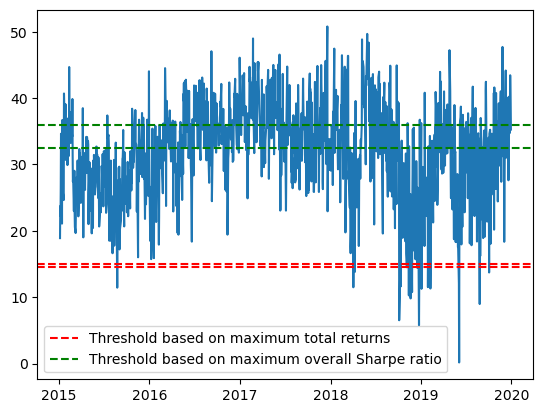

In [184]:
plt.plot(portfolio_df_sent_lag1['sentiment_lag1'])
plt.axhline(14.5, color = 'red', linestyle = '--')
plt.axhline(15, color = 'red', linestyle = '--', label = 'Threshold based on maximum total returns')
plt.axhline(32.5, color = 'green', linestyle = '--', label = 'Threshold based on maximum overall Sharpe ratio')
plt.axhline(36, color = 'green', linestyle = '--')
plt.legend()

### Moving average of sentiment 